In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib.image as mpimg
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install -q torch torchvision segmentation-models-pytorch tifffile numpy matplotlib scikit-learn torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.7 MB/s eta 0:00:00


In [4]:
import os
import numpy as np
import torch
import tifffile
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchmetrics import MetricCollection
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score, BinaryPrecision, BinaryRecall

## 1. Preprocessing and Data Loading

In [10]:
# Replace the entire WaterDataset class with this version

class WaterDataset(Dataset):
    """
    This version handles pairing one image with multiple mask files,
    merging them into a single mask, and corrects image dimension order.
    """
    def __init__(self, data_pairs):
        self.data_pairs = data_pairs

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        image_path, mask_paths = self.data_pairs[idx]

        # --- REVISED IMAGE LOADING LOGIC ---
        image = tifffile.imread(image_path).astype(np.float32)

        # Detect if channels are in the last dimension and move them to the first
        if image.shape[-1] == 12:
            image = np.moveaxis(image, source=-1, destination=0) # (H, W, C) -> (C, H, W)
        # --- END OF REVISED LOGIC ---

        # Normalization logic remains the same
        min_val = image.min()
        max_val = image.max()
        if max_val > min_val:
            image = (image - min_val) / (max_val - min_val)

        # Mask loading logic remains the same
        final_mask = np.zeros((128, 128), dtype=np.float32)
        # ... (rest of the mask loading code is unchanged) ...
        for mask_path in mask_paths:
            current_mask = mpimg.imread(mask_path)
            if current_mask.ndim == 3:
                current_mask = current_mask[:, :, 0]
            current_mask = (current_mask > 0).astype(np.float32)
            final_mask = np.logical_or(final_mask, current_mask).astype(np.float32)
            
        final_mask = np.expand_dims(final_mask, axis=0)

        return torch.from_numpy(image), torch.from_numpy(final_mask)

## 2. Visualization

In [11]:
def visualize_bands(image_path: str, title: str = "Band Visualization"):
    """
    Loads a 12-channel TIFF image and displays each band.
    Handles both (C, H, W) and (H, W, C) formats.
    """
    image = tifffile.imread(image_path)

    # Detect if channels are in the last dimension and move them to the first
    if image.shape[-1] == 12:
        image = np.moveaxis(image, source=-1, destination=0) # (H, W, C) -> (C, H, W)

    # Now the check should pass
    if image.shape[0] != 12:
        print(f"Error: After reordering, still expected 12 channels, but got {image.shape[0]}")
        return

    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    fig.suptitle(title, fontsize=16)
    
    for i, ax in enumerate(axes.ravel()):
        ax.imshow(image[i], cmap='gray')
        ax.set_title(f'Band {i + 1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

## 3. Model Training and Evaluation


In [12]:
## Training loop function
def train_model(model, train_loader, val_loader, loss_fn, optimizer, metrics, device, epochs):
    """
    Handles the model training and validation loop.
    """
    print("🚀 Starting training...")
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                # Update metrics
                metrics.update(outputs, labels.int())

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        # Compute metrics for the epoch
        results = metrics.compute()
        
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"IoU: {results['BinaryJaccardIndex']:.4f} | "
              f"F1: {results['BinaryF1Score']:.4f} | "
              f"Precision: {results['BinaryPrecision']:.4f} | "
              f"Recall: {results['BinaryRecall']:.4f}")

        # Reset metrics for the next epoch
        metrics.reset()
    
    print("Training finished.")


### Configuration and device setup

In [13]:
IMAGE_DIR = "/kaggle/input/water-segmentation/data/images"
MASK_DIR = "/kaggle/input/water-segmentation/data/labels"
BATCH_SIZE = 16
EPOCHS = 25
LEARNING_RATE = 1e-4

# --- Setup Device ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Data loading and preparation

Displaying bands of a sample training image...


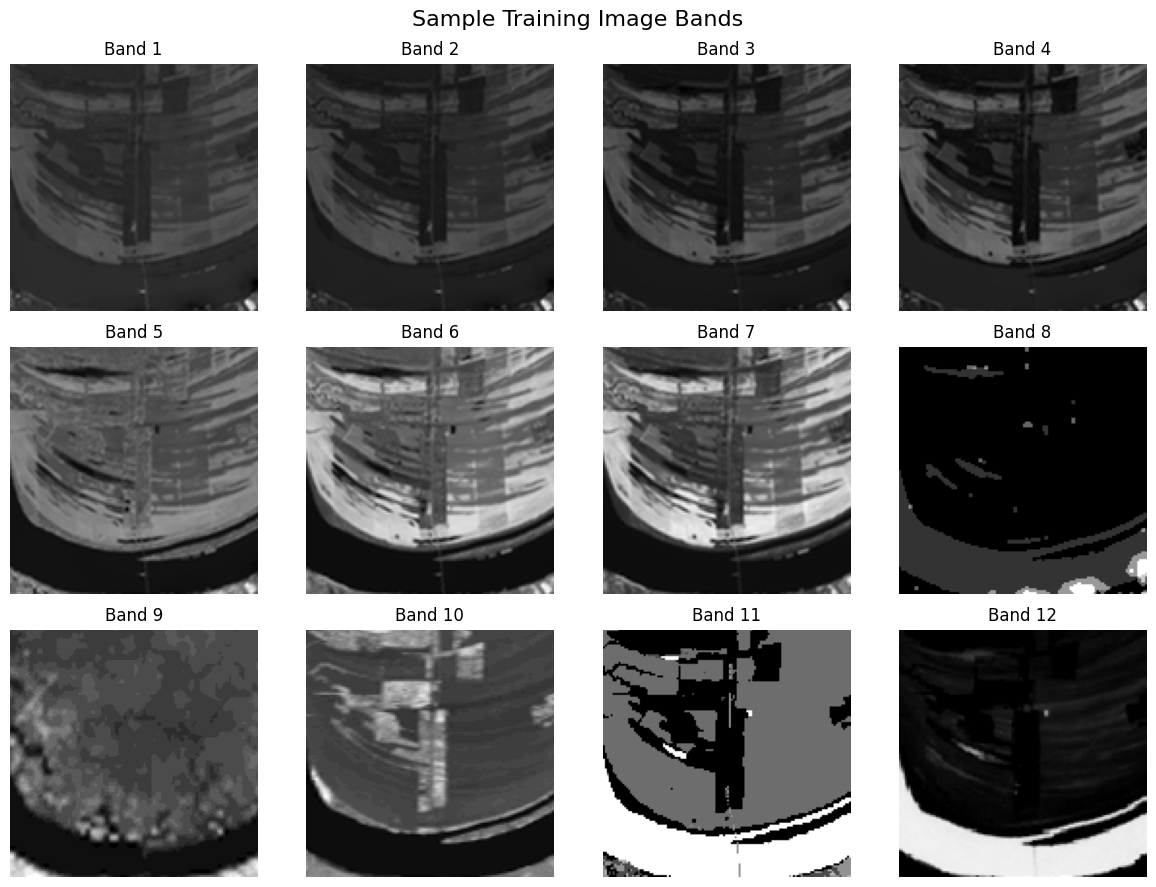

In [14]:
# --- Load Data Paths and Pair Them ---
image_files = sorted([os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR) if f.endswith('.tif')])
all_mask_files = sorted([os.path.join(MASK_DIR, f) for f in os.listdir(MASK_DIR) if f.endswith('.png')])

if not image_files or not all_mask_files:
    raise ValueError("Image or mask directory is empty. Please check your directory structure.")

# Create a list of (image_path, [mask_paths]) pairs
data_pairs = []
for img_path in image_files:
    # Get the base name of the image, e.g., "101" from "images/101.tif"
    img_basename = os.path.splitext(os.path.basename(img_path))[0]
    
    # Find all masks that start with this base name
    corresponding_masks = [
        mask_path for mask_path in all_mask_files 
        if os.path.basename(mask_path).startswith(img_basename)
    ]
    
    if corresponding_masks:
        data_pairs.append((img_path, corresponding_masks))

# --- Split data into training and validation sets (80/20 split) ---
train_pairs, val_pairs = train_test_split(data_pairs, test_size=0.2, random_state=42)

# --- Create Datasets and DataLoaders (pass the paired data) ---
train_dataset = WaterDataset(train_pairs)
val_dataset = WaterDataset(val_pairs)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Visualize one sample from the training set ---
print("Displaying bands of a sample training image...")
# Note the change here to get the image path from the pair
visualize_bands(train_pairs[0][0], title="Sample Training Image Bands")



## Training

In [15]:
# --- 4. Model Architecture, Loss, and Optimizer ---
print("🧠 Initializing U-Net model...")
# ... (model definition is correct) ...
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=12,
    classes=1,
).to(device)

# Change this line to use PyTorch's built-in loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ... (rest of the code) ...
# --- Evaluation Metrics ---
# We use a MetricCollection to manage multiple metrics efficiently
metrics = MetricCollection({
    'BinaryJaccardIndex': BinaryJaccardIndex(), # IoU
    'BinaryF1Score': BinaryF1Score(),
    'BinaryPrecision': BinaryPrecision(),
    'BinaryRecall': BinaryRecall(),
}).to(device)

# --- Start Training ---
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metrics=metrics,
    device=device,
    epochs=EPOCHS
)

# --- Save the trained model ---
model_save_path = "water_segmentation_unet.pth"
torch.save(model.state_dict(), model_save_path)
print(f"💾 Model saved to {model_save_path}")

🧠 Initializing U-Net model...
🚀 Starting training...
Epoch 1/25 | Train Loss: 0.7201 | Val Loss: 0.6980 | IoU: 0.3433 | F1: 0.5111 | Precision: 0.4785 | Recall: 0.5486
Epoch 2/25 | Train Loss: 0.6393 | Val Loss: 0.6952 | IoU: 0.3360 | F1: 0.5030 | Precision: 0.6247 | Recall: 0.4210
Epoch 3/25 | Train Loss: 0.5603 | Val Loss: 0.6661 | IoU: 0.3884 | F1: 0.5594 | Precision: 0.6559 | Recall: 0.4877
Epoch 4/25 | Train Loss: 0.5100 | Val Loss: 0.6695 | IoU: 0.4143 | F1: 0.5859 | Precision: 0.6783 | Recall: 0.5157
Epoch 5/25 | Train Loss: 0.4632 | Val Loss: 0.6706 | IoU: 0.4264 | F1: 0.5979 | Precision: 0.6598 | Recall: 0.5466
Epoch 6/25 | Train Loss: 0.4487 | Val Loss: 0.6235 | IoU: 0.4535 | F1: 0.6240 | Precision: 0.7468 | Recall: 0.5358
Epoch 7/25 | Train Loss: 0.4257 | Val Loss: 0.6283 | IoU: 0.4407 | F1: 0.6118 | Precision: 0.6832 | Recall: 0.5538
Epoch 8/25 | Train Loss: 0.3881 | Val Loss: 0.6694 | IoU: 0.4452 | F1: 0.6162 | Precision: 0.6847 | Recall: 0.5601
Epoch 9/25 | Train Loss: 0.

## Test Model

Using device: cuda
🧠 Loading model...
✅ Model loaded successfully.

--- Testing image: 0.tif ---


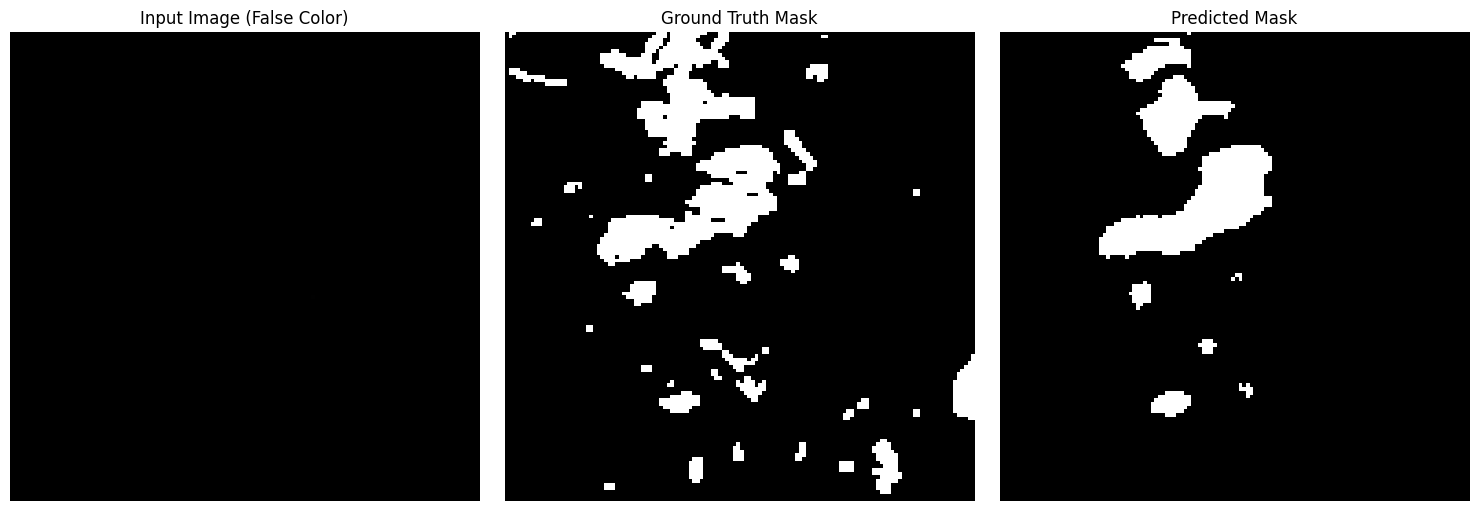


--- Testing image: 1.tif ---


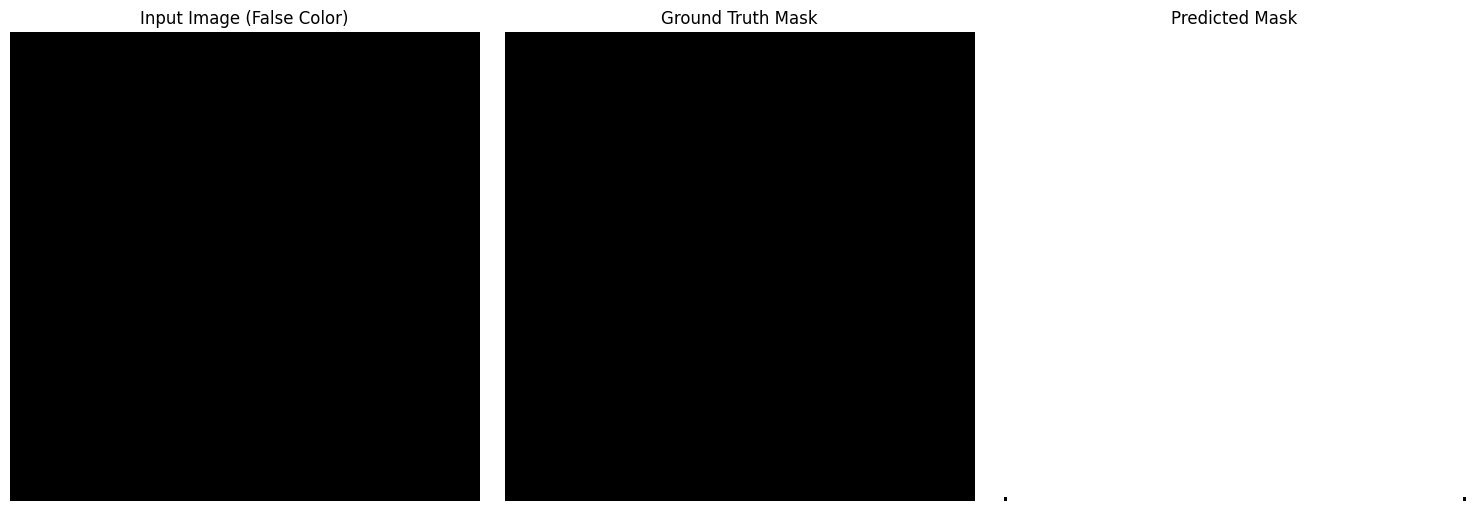


--- Testing image: 10.tif ---


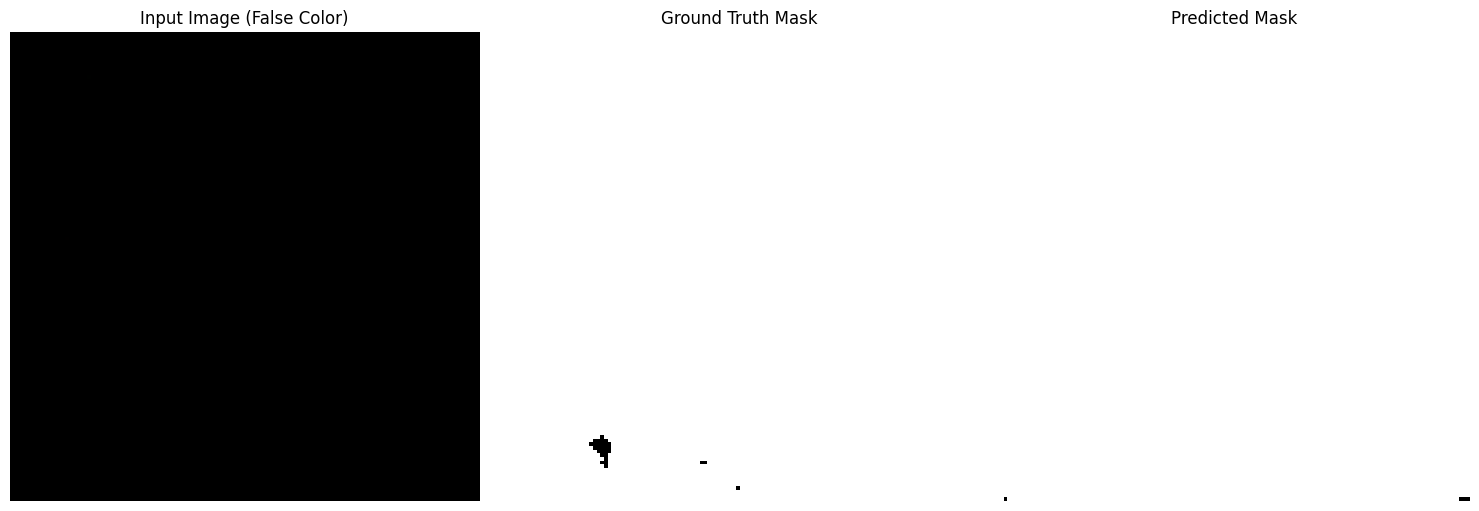

In [17]:
import os
import torch
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import segmentation_models_pytorch as smp

def predict(model, image_path, device):
    """
    Performs inference on a single image.
    """
    model.eval()  # Set the model to evaluation mode

    # 1. Load and preprocess the image
    image = tifffile.imread(image_path).astype(np.float32)

    # Correct dimension order: (H, W, C) -> (C, H, W)
    if image.shape[-1] == 12:
        image = np.moveaxis(image, source=-1, destination=0)
    
    # Normalize the image
    min_val = image.min()
    max_val = image.max()
    if max_val > min_val:
        image = (image - min_val) / (max_val - min_val)

    # Convert to tensor and add batch dimension
    input_tensor = torch.from_numpy(image).unsqueeze(0).to(device)

    # 2. Perform prediction
    with torch.no_grad():
        logits = model(input_tensor)
    
    # 3. Post-process the output
    # Apply sigmoid to get probabilities, then threshold to get a binary mask
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).squeeze(0).squeeze(0).cpu().numpy()
    
    return preds

def visualize_prediction(image_path, true_mask_paths, predicted_mask):
    """
    Visualizes the input image, true mask, and predicted mask.
    """
    # --- 1. Prepare the input image for visualization (False-Color Composite) ---
    # We create an RGB-like image using 3 of the 12 bands.
    # Bands 4, 3, 2 are often used for a natural-looking false-color image.
    full_image = tifffile.imread(image_path)
    if full_image.shape[0] == 12: # If channels are first
        rgb_bands = full_image[[3, 2, 1], :, :] # Bands 4, 3, 2
    else: # If channels are last
        rgb_bands = full_image[:, :, [3, 2, 1]]
        rgb_bands = np.moveaxis(rgb_bands, source=-1, destination=0)
    
    # Normalize each band to 0-1 for display
    for i in range(rgb_bands.shape[0]):
        min_val, max_val = rgb_bands[i].min(), rgb_bands[i].max()
        if max_val > min_val:
            rgb_bands[i] = (rgb_bands[i] - min_val) / (max_val - min_val)
    
    display_image = np.moveaxis(rgb_bands, source=0, destination=-1)

    # --- 2. Prepare the ground truth mask ---
    true_mask = np.zeros((128, 128), dtype=np.float32)
    for mask_path in true_mask_paths:
        current_mask = mpimg.imread(mask_path)
        if current_mask.ndim == 3:
            current_mask = current_mask[:, :, 0]
        current_mask = (current_mask > 0).astype(np.float32)
        true_mask = np.logical_or(true_mask, current_mask).astype(np.float32)

    # --- 3. Create the plot ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(display_image)
    axes[0].set_title("Input Image (False Color)")
    axes[0].axis('off')

    axes[1].imshow(true_mask, cmap='gray')
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')

    axes[2].imshow(predicted_mask, cmap='gray')
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# --- Configuration ---
MODEL_PATH = "/kaggle/working/water_segmentation_unet.pth"
# Create these directories and place some test images/masks in them
TEST_IMAGE_DIR = "/kaggle/input/water-segmentation/data/images" 
TEST_MASK_DIR = "/kaggle/input/water-segmentation/data/labels"

# --- Setup Device ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- 1. Load Model ---
print("🧠 Loading model...")
# Instantiate the exact same model architecture as during training
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None, # No need to load imagenet weights, we're loading our own
    in_channels=12,
    classes=1,
)
# Load the saved weights
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device(device)))
model.to(device)
print("✅ Model loaded successfully.")

# --- 2. Load Test Data and Predict ---
test_image_files = sorted([os.path.join(TEST_IMAGE_DIR, f) for f in os.listdir(TEST_IMAGE_DIR) if f.endswith('.tif')])
all_mask_files = sorted([os.path.join(TEST_MASK_DIR, f) for f in os.listdir(TEST_MASK_DIR) if f.endswith('.png')])

# Select a few images to test
num_test_images = 3
for img_path in test_image_files[:num_test_images]:
    print(f"\n--- Testing image: {os.path.basename(img_path)} ---")
    
    # Predict the mask
    predicted_mask = predict(model, img_path, device)

    # Find corresponding ground truth mask(s)
    img_basename = os.path.splitext(os.path.basename(img_path))[0]
    true_mask_paths = [
        mask_path for mask_path in all_mask_files 
        if os.path.basename(mask_path).startswith(img_basename)
    ]
    
    # Visualize the results
    visualize_prediction(img_path, true_mask_paths, predicted_mask)